In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add the parent directory (project root) to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

Added to path: D:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE


In [3]:
%%writefile ../src/master_state.py

"""
Master State for Integrated Space Biology Research Workflow

Based on the full agent pattern but simplified for sequential execution.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class MasterResearchState(TypedDict):
    """
    Master state combining scoping and retrieval workflows.
    
    Follows the full agent pattern but keeps only essential fields.
    """
    
    # === CORE CONVERSATION ===
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
    # === SCOPING RESULTS ===
    retrieval_brief: Optional[str]
    
    # === RETRIEVAL RESULTS (keeping your existing fields) ===
    retriever_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int  # Your existing field
    compressed_notes: str
    raw_notes: Annotated[List[str], operator.add]
    
    # === WORKFLOW CONTROL ===
    next_step: str  # Following the reference pattern for routing

Overwriting ../src/master_state.py


In [4]:
%%writefile ../src/research_orchestrator.py

"""
Research Orchestrator - Main Workflow Controller

Based on the full agent orchestration pattern from the reference.
Coordinates between scoping and retrieval phases.
"""

from typing_extensions import Literal
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END

from src.master_state import MasterResearchState
from src.retrieval_agent_scope import scope_research  
from src.retrieval_agent import retrieval_agent
from src.prompts import final_report_generation_prompt
from src.utils import get_today_str

# Initialize orchestrator model
orchestrator_model = init_chat_model(model="openai:gpt-4o-mini", temperature=0)

def research_orchestrator(state: MasterResearchState) -> dict:
    """
    Main orchestrator that decides the next step in research process.
    
    Following the reference pattern for workflow coordination.
    """
    
    # Check current state to determine next action
    has_brief = bool(state.get("retrieval_brief"))
    has_research = bool(state.get("compressed_notes"))
    
    if not has_brief:
        return {"next_step": "scoping"}
    elif has_brief and not has_research:
        return {"next_step": "retrieval"}
    else:
        return {"next_step": "synthesis"}

def scoping_node(state: MasterResearchState) -> dict:
    """
    Execute scoping workflow and update master state.
    
    Calls your existing scoping agent and integrates results.
    """
    
    # Prepare input for scoping workflow
    scoping_input = {
        "messages": state.get("messages", [])
    }
    
    # Execute scoping workflow
    scoping_result = scope_research.invoke(scoping_input)
    
    # Update master state with scoping results
    updates = {
        "messages": scoping_result.get("messages", [])
    }
    
    # Check if we got a retrieval brief
    if scoping_result.get("retrieval_brief"):
        updates["retrieval_brief"] = scoping_result["retrieval_brief"]
        updates["next_step"] = "retrieval"
    else:
        updates["next_step"] = "complete"  # Clarification question was asked
    
    return updates

def retrieval_node(state: MasterResearchState) -> dict:
    """
    Execute retrieval workflow and update master state.
    
    Calls your existing retrieval agent with the research brief.
    """
    
    # Prepare input for retrieval workflow
    retrieval_input = {
        "retriever_messages": [HumanMessage(content=state["retrieval_brief"])],
        "tool_call_iterations": 0,
        "retrieval_topic": state["retrieval_brief"],
        "compressed_notes": "",
        "raw_notes": []
    }
    
    # Execute retrieval workflow  
    retrieval_result = retrieval_agent.invoke(retrieval_input)
    
    # Update master state with retrieval results
    return {
        "retriever_messages": retrieval_result.get("retriever_messages", []),
        "compressed_notes": retrieval_result.get("compressed_notes", ""),
        "raw_notes": retrieval_result.get("raw_notes", []),
        "tool_call_iterations": len(retrieval_result.get("retriever_messages", [])),
        "next_step": "synthesis"
    }

def synthesis_node(state: MasterResearchState) -> dict:
    """
    Create final synthesized response using the final_report_generation_prompt.
    
    Uses your existing prompt template for consistent formatting.
    """
    
    compressed_notes = state.get("compressed_notes", "")
    retrieval_brief = state.get("retrieval_brief", "Unknown research topic")
    
    # Use your existing final report generation prompt
    try:
        final_response = orchestrator_model.invoke([
            HumanMessage(content=final_report_generation_prompt.format(
                date=get_today_str(),
                research_topic=retrieval_brief,
                research_findings=compressed_notes
            ))
        ])
        
        response_content = final_response.content
    except Exception as e:
        # Fallback if synthesis fails
        response_content = f"""Based on space biology research literature:

        **Research Topic:** {retrieval_brief}

        **Findings:**
        {compressed_notes}

        This information was compiled from multiple research papers in our space biology knowledge base."""

    return {
        "messages": [AIMessage(content=response_content)],
        "next_step": "complete"
    }

# Routing function following reference pattern
def route_next_step(state: MasterResearchState) -> Literal["scoping", "retrieval", "synthesis", "__end__"]:
    """Route to next step based on workflow state."""
    
    next_step = state.get("next_step", "scoping")
    
    if next_step == "complete":
        return "__end__"
    else:
        return next_step

Overwriting ../src/research_orchestrator.py


In [5]:
%%writefile ../src/master_research_workflow.py

"""
Master Research Workflow

Complete orchestration following the full agent pattern from reference.
"""

from langgraph.graph import StateGraph, START, END
from src.master_state import MasterResearchState
from src.research_orchestrator import (
    research_orchestrator,
    scoping_node, 
    retrieval_node,
    synthesis_node,
    route_next_step
)

def create_master_research_workflow():
    """
    Create the complete research workflow following reference architecture.
    """
    
    # Initialize workflow graph
    workflow = StateGraph(MasterResearchState)
    
    # Add orchestrator and workflow nodes
    workflow.add_node("orchestrator", research_orchestrator)
    workflow.add_node("scoping", scoping_node)
    workflow.add_node("retrieval", retrieval_node)
    workflow.add_node("synthesis", synthesis_node)
    
    # Start with orchestrator
    workflow.add_edge(START, "orchestrator")
    
    # Route from orchestrator to appropriate workflow step
    workflow.add_conditional_edges(
        "orchestrator",
        route_next_step,
        {
            "scoping": "scoping",
            "retrieval": "retrieval", 
            "synthesis": "synthesis",
            "__end__": END
        }
    )
    
    # After each step, return to orchestrator for next routing decision
    workflow.add_edge("scoping", "orchestrator")
    workflow.add_edge("retrieval", "orchestrator") 
    workflow.add_edge("synthesis", END)
    
    return workflow.compile()

# Create the master workflow
master_research_agent = create_master_research_workflow()

Overwriting ../src/master_research_workflow.py


d:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


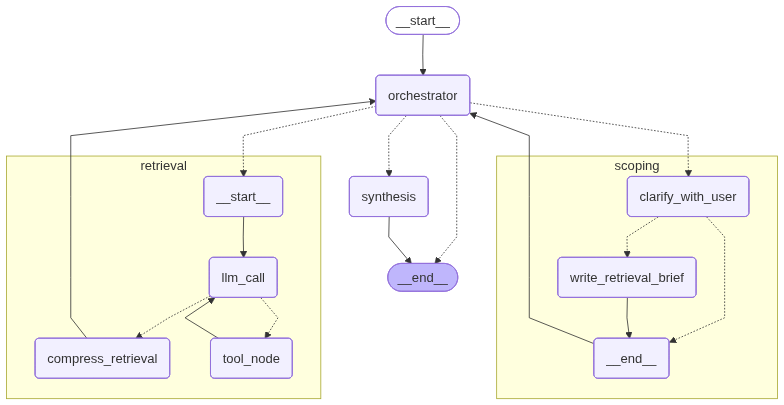

In [6]:
# Display workflow graph
from IPython.display import Image, display
from src.master_research_workflow import master_research_agent

display(Image(master_research_agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Test complete research workflow with Rich Markdown display
from utils import format_messages
from langchain_core.messages import HumanMessage
from rich.markdown import Markdown

# Test with a research question
research_question = "How does microgravity affect bone density in astronauts during long-duration space missions?"

print(f"🔬 Research Question: {research_question}")
print("=" * 50)

# Execute complete workflow
result = master_research_agent.invoke({
    "messages": [HumanMessage(content=research_question)],
    "next_step": "scoping",
    "tool_call_iterations": 0,
    "compressed_notes": "",
    "raw_notes": [],
    "retriever_messages": []
})

# Extract the final response content and display with Rich Markdown
final_response = result["messages"][-1].content

print("🎯 FINAL RESEARCH RESPONSE:")
print("=" * 50)
Markdown(final_response)

🔬 Research Question: How does microgravity affect bone density in astronauts during long-duration space missions?


D:\SPACE-BIOLOGY-KNOWLEDGE-ENGINE\src\utils.py:62: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  vector_store = Qdrant(


🎯 FINAL RESEARCH RESPONSE:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Physiological Mechanisms of Bone Density Loss in Microgravity and Countermeasures                ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Long-duration space missions expose astronauts to microgravity, which significantly impacts their bone health. This
report explores the physiological mechanisms behind bone density loss in microgravity and the countermeasures that 
have been researched or implemented to mitigate these effects.                                                     


                                   Physiological Mechanisms of Bone Density Loss                                   

                                    Altered Osteoblast and Osteoclast Activity                                     

Microgravity affects the balance between osteoblasts (cells responsible for bone formation) and osteoclasts (cells 
responsible for bone resorption). In microgravity, there is a notable increase in osteoclast activity, leading to  
enhanced bone resorption. Concurrently, osteoblast activity is diminished, resulting in a net loss of bone density.
This imbalance is further complicated by an increase in bone marrow adipose tissue (MAT), which correlates with    
declines in bone mass, indicating a dual process of bone density reduction and fat accumulation.                   

                                              Site-Specific Bone Loss                                              

Research has shown that astronauts experience site-specific bone loss, particularly in weight-bearing areas such as
the hip and spine. For instance, astronauts returning from missions on the International Space Station (ISS)       
exhibit a decrease in areal bone mineral density (aBMD) of approximately 1.4–1.5% per month in the hip and 0.9% in 
the spine. Cancellous bone, which is the spongy bone found at the ends of long bones and in the interiors of       
others, shows even more pronounced losses, reaching rates of 2.2–2.7% per month. This targeted loss can lead to    
increased fracture risk upon return to Earth.                                                                      

                                            Mimicking Accelerated Aging                                            

The changes in bone health induced by microgravity resemble the bone deterioration seen in aging humans. This      
accelerated aging effect heightens the risk of fractures and other skeletal issues, as astronauts may return with  
bone health comparable to that of much older individuals.                                                          

                                                Bone Marrow Changes                                                

Microgravity conditions lead to significant changes in bone marrow composition, particularly an increase in MAT.   
This shift is associated with osteoclast-mediated bone resorption and may involve osteocytic osteolysis, a process 
where osteocytes (mature bone cells) contribute to bone loss. The cumulative effect of these changes results in    
reduced mechanical properties of the bone, making it more susceptible to fractures.                                


                                   Countermeasures to Mitigate Bone Density Loss                                   

                                                 Exercise Regimens                                                 

Exercise is a primary countermeasure against bone density loss in space. Astronauts engage in resistance and       
aerobic exercise regimens designed to stimulate bone maintenance. However, despite these efforts, some studies     
indicate that bone mineral density (BMD) loss persists, suggesting that current exercise protocols may not be fully
effective in counteracting the effects of